<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/LIDC_Georges_End_to_End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LIDC GDRO: Looking at Clustered Subgroups

Thomas Zeng

## Notebook Setup

Setup autoreload extension

In [1]:
%load_ext autoreload
%autoreload 2

Clone repo (if on colab)

In [2]:
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO
# %cd ..

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 3688, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 3688 (delta 152), reused 258 (delta 152), pack-reused 3428
Receiving objects: 100% (3688/3688), 81.77 MiB | 3.61 MiB/s, done.
Resolving deltas: 100% (3300/3300), done.
Checking out files: 100% (5414/5414), done.
/content/LIDC_GDRO


In [45]:
# !git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/mtzig/LIDC_GDRO
   e286643..4bcf9f5  main       -> origin/main
Updating e286643..4bcf9f5
Fast-forward
 image_data_utils.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)


import necessary libraries

In [9]:
# !pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.4 MB/s 
     |████████████████████████████████| 1.1 MB 53.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=64703330d665a7149644a32f268f672595c4b2a9d74096365297756d95e1de46
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=287b42d12502e9b1861f7f79f04a2fdacc1a4b0d2c35101c9b54fdfbbfaeff7e
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [46]:
import pandas as pd
import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import NoduleDataset, SubclassedNoduleDataset
from models import TransferModel
from train import train, test
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
# import torchvision
from torchvision import transforms
import torch
from image_data_utils import getImages, train_epochs, show_scatter

from umap import UMAP
# from matplotlib import pyplot as plt
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

Get available Device

In [11]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


## ERM Model: Training ERM model to extract CNN features

### ERM Modeling

Just for visulalization, the csv where we get the train, cv, test splits and subgroups come from below csv. 

In [12]:
df_splits = pd.read_csv('./data/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,spiculation,malignancy,split
0,836,1,0,0
1,1863,1,0,0
2,2201,0,0,0
3,1111,0,0,0
4,1894,0,0,0


First we load in the training data

In [13]:
train_data, cv_data, test_data = getImages(split=True, sublabels='malignancy', binary=True, device=DEVICE)

#datasets
tr = SubclassedNoduleDataset(*train_data)
cv = SubclassedNoduleDataset(*cv_data)
tst = SubclassedNoduleDataset(*test_data)

#dataloaders
tr_loader = InfiniteDataLoader(tr, batch_size=512)
cv_loader = InfiniteDataLoader(cv, len(cv))
tst_loader = InfiniteDataLoader(tst, len(tst))

Next we initialize the model!

In [14]:
model = TransferModel(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Now we train the model

In [15]:
epochs = 15
train_epochs(epochs, tr_loader, cv_loader, model, loss_fn='ERM',scheduler=True, verbose=False)

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.
Epoch 14/15
Epoch 15/15


In [16]:
test(tst_loader,model)

(0.8604651162790697,
 0.9384615384615385,
 0.84,
 0.7702702702702703,
 0.972972972972973)

### Feature Extraction

We first save model weights (for reproducibility)

In [17]:
 torch.save(model.state_dict(), './data/erm_cluster_weights.pt')

Next we add hooks to let us get activations

In [18]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.model.avgpool.register_forward_hook(get_activation('avgpool'))

We re get the data, but in its entirety with the noduleID

In [19]:
noduleID, data = getImages(split=False, binary=True, device=DEVICE)

Now we extract features

In [20]:
imgs = torch.stack(data[0])
model(imgs)
img_features = activation['avgpool'].squeeze()

We collect all the features in a dataframe

In [22]:
cols = []
for idx,id in enumerate(noduleID):
  cols.append([id] + img_features[idx].cpu().numpy().tolist())
df_features = pd.DataFrame(cols).rename({0:'noduleID'}, axis=1)

splits = [df_splits[df_splits['noduleID'] == id]['split'].iloc[0] for id in  df_features['noduleID']]
malig = [df_splits[df_splits['noduleID'] == id]['malignancy'].iloc[0] for id in  df_features['noduleID']]

df_features['split'] = splits
df_features['malignancy'] = malig
df_features['malignancy_b'] = np.where(df_features['malignancy']>1, 1, 0)
df_features.head()

,noduleID,1,2,3,4,5,6,7,8,9,...,506,507,508,509,510,511,512,split,malignancy,malignancy_b
0,256,1.822303,0.883496,0.630974,0.0,0.000000,0.144747,0.989825,0.142740,0.116373,...,0.019549,0.000000,1.745502,0.000000,0.708168,0.239255,0.108250,0,0,0
1,2341,1.646644,0.000000,0.424563,0.0,0.045549,0.000000,0.824661,0.051335,0.185484,...,0.244314,0.054744,0.686821,0.000000,0.195056,0.611862,0.183027,0,0,0
2,2114,1.447641,1.404909,1.875261,0.0,0.000000,0.000000,1.089202,0.000000,0.000000,...,1.029779,0.000000,1.462384,0.086014,1.383066,0.000000,0.005686,0,0,0
3,1667,2.276172,0.233924,1.059740,0.0,0.000000,0.321852,0.906121,0.421460,0.090436,...,0.189179,0.000000,2.214041,0.000000,0.255908,0.172343,0.054638,0,0,0
4,2274,1.974773,1.059517,1.512367,0.0,0.009898,0.000000,0.953794,0.000000,0.143947,...,0.162572,0.030686,2.172146,0.063038,1.400073,0.728207,0.109305,0,0,0


We again save the data for reproducibility

In [23]:
df_features.to_csv('./data/erm_cluster_cnn_features.csv')

## Feature Reduce and Cluster

### Feature Reduce

First we split df into two by the splits

In [24]:
df_features_train = df_features[df_features['split'] == 0]
df_features_cv_test = df_features[df_features['split'] != 0]

Next we get the features in an array

In [25]:
train_features = df_features_train.drop(['noduleID', 'split', 'malignancy', 'malignancy_b'], axis=1).values
cv_test_features = df_features_cv_test.drop(['noduleID', 'split', 'malignancy', 'malignancy_b'], axis=1).values

Following the George paper, we use UMAP to dimensionaly reduce our data

In [26]:
reducer = UMAP(random_state=8)
reducer.fit(train_features)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


UMAP(random_state=8, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [27]:
train_embeds = reducer.transform(train_features)

Now we visualize the reduction on train dataset

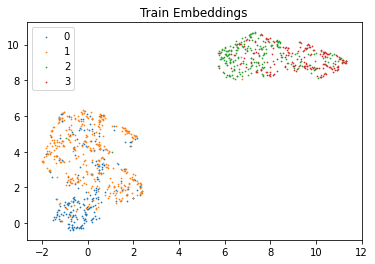

In [48]:
show_scatter(train_embeds[:, 0], train_embeds[:, 1],df_features_train['malignancy'],'Train Embeddings', 0.5)



We also do same visualization on cv and test

In [29]:
cv_test_embeds = reducer.transform(cv_test_features)

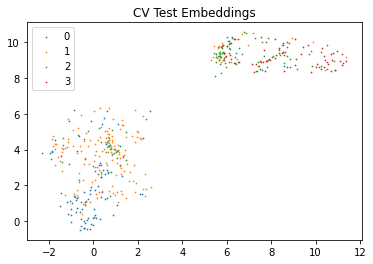

In [49]:
show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],df_features_cv_test['malignancy'],'CV Test Embeddings', 0.5)


We now save the reduce

In [31]:
f_reducer = './cnn_umap_reducer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))

### Feature Cluster

Now we cluster the training embeddings using Gaussian Mixture

We first visualize the silhouette score

(we only cluster on malignant since that is what we want)

In [50]:
train_embeds_malig = reducer.transform(train_features[df_features_train['malignancy_b'] == 1])

Text(0, 0.5, 'Silhouette Coefficients')

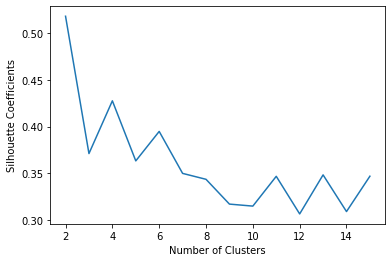

In [51]:
clusters = [n for n in range(2,16)]
silhouette_coefficients = []

for cluster in clusters:
  gmm = GaussianMixture(n_components=cluster, random_state=61).fit(train_embeds_malig)
  labels = gmm.predict(train_embeds_malig)
  
  silhouette_avg = silhouette_score(train_embeds_malig, labels)
  silhouette_coefficients.append(silhouette_avg)

plt.plot(clusters, silhouette_coefficients)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')

We note from above, the best number of subclasses is 2.

In [52]:
clusterer = GaussianMixture(n_components=2, random_state=61).fit(train_embeds_malig)

We now visualize the clusters ont train

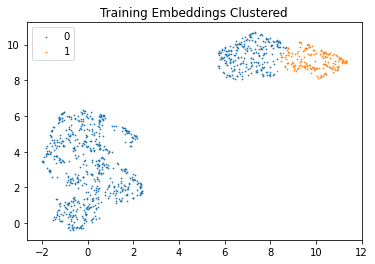

In [54]:
train_labels = clusterer.predict(train_embeds)

show_scatter(train_embeds[:, 0], train_embeds[:, 1],train_labels,'Training Embeddings Clustered', 0.5)

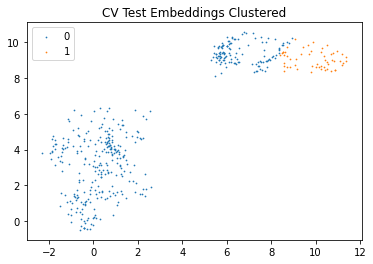

In [55]:
cv_test_labels = clusterer.predict(cv_test_embeds)

show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],cv_test_labels,'CV Test Embeddings Clustered', 0.5)